### 1. Data Download
Data was downloaded with following [script](./download_data.sh). For the train services tables I included the ones from 2019 to 2024 excluding 2025 cause it's not available for the full year yet.

### 2.

In [ ]:
import duckdb

db = duckdb.connect("data/duckdb_trains.db")

db.sql("""
CREATE TABLE IF NOT EXISTS stations AS
FROM "data/stations-2023.csv"
""")

### 3.

In [22]:
db.sql("""
CREATE TABLE IF NOT EXISTS distances AS
FROM read_csv("data/inter-station-2022.csv", nullstr='XXX')
""")

In [24]:
db.sql("""
CREATE TABLE distances_long AS
    UNPIVOT distances
    ON COLUMNS (* EXCLUDE station)
    INTO NAME other_station VALUE distance;
""")

In [30]:
db.sql("SHOW TABLES")

┌────────────────┐
│      name      │
│    varchar     │
├────────────────┤
│ distances      │
│ distances_long │
│ stations       │
└────────────────┘

### 4.

In [32]:
conn_string = "host=localhost user=postgres password=postgres dbname=postgres"

db.sql(f"""
ATTACH IF NOT EXISTS '{conn_string}' AS postgres_db (TYPE postgres);
""")

In [34]:
db.sql("""
CREATE TABLE IF NOT EXISTS postgres_db.disruptions AS
FROM "data/disruptions-*.csv"
""")

### 5.

In [37]:
duckdb.sql("""
COPY (SELECT * FROM "data/services-*.csv") TO "data/services.parquet" (FORMAT PARQUET, COMPRESSION zstd);
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [38]:
db.sql("""
CREATE TABLE IF NOT EXISTS services AS
FROM "data/services.parquet"
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [39]:
db.sql("SHOW ALL TABLES")

┌───────────────┬─────────┬────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

### 7.

#### 1.

In [64]:
db.sql("""
SELECT COUNT(*) FROM services
WHERE "Stop:Station name" = 'Amsterdam Centraal'
    AND "Stop:Departure time" is not NULL
""")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│      1667971 │
└──────────────┘

#### 2.

In [65]:
db.sql("""
SELECT "Service:Type", mean("Stop:Arrival delay") as average_delay FROM services
WHERE "STOP:Arrival delay" is not NULL
GROUP BY "Service:Type"
ORDER BY average_delay DESC
""")

┌──────────────────────┬────────────────────┐
│     Service:Type     │   average_delay    │
│       varchar        │       double       │
├──────────────────────┼────────────────────┤
│ Alpen Express        │  31.84254143646409 │
│ Krokus Express       │ 18.304347826086957 │
│ European Sleeper     │ 12.175902506323293 │
│ Nightjet             │  9.012493009863528 │
│ Eurostar             │   6.91274113952445 │
│ Thalys               │ 5.3961896909446025 │
│ ICE International    │  5.308921044515267 │
│ Int. Trein           │  4.947807104584243 │
│ Nachttrein           │   4.27683615819209 │
│ Stoomtrein           │  3.366863905325444 │
│     ·                │                 ·  │
│     ·                │                 ·  │
│     ·                │                 ·  │
│ Metro i.p.v. trein   │                0.0 │
│ stoptrein            │                0.0 │
│ Metro                │                0.0 │
│ Belbus               │                0.0 │
│ Tram ipv trein       │          

#### 3.

In [77]:
db.sql("""
SELECT year("start_time"), MODE("cause_en") FROM postgres_db.disruptions
GROUP BY year(start_time)
ORDER BY year(start_time)    
""")

┌────────────────────┬───────────────────┐
│ "year"(start_time) │ "mode"(cause_en)  │
│       int64        │      varchar      │
├────────────────────┼───────────────────┤
│               2011 │ broken down train │
│               2012 │ points failure    │
│               2013 │ points failure    │
│               2014 │ broken down train │
│               2015 │ broken down train │
│               2016 │ broken down train │
│               2017 │ broken down train │
│               2018 │ broken down train │
│               2019 │ broken down train │
│               2020 │ broken down train │
│               2021 │ broken down train │
│               2022 │ broken down train │
│               2023 │ broken down train │
├────────────────────┴───────────────────┤
│ 13 rows                      2 columns │
└────────────────────────────────────────┘

#### 4.

In [98]:
db.sql("""
SELECT COUNT(*) FROM services
WHERE "Stop:Arrival time" is not NULL
       AND "Stop:Station name" LIKE 'Amsterdam%';
""")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│      7499014 │
└──────────────┘

#### 5.

In [163]:
db.sql("""
SELECT ROUND(AVG(CASE WHEN stations.code IS NULL THEN 1 ELSE 0 END) * 100, 2) as percentage FROM services
LEFT OUTER JOIN stations on "Stop:Station code" = stations.code
""")

┌────────────┐
│ percentage │
│   double   │
├────────────┤
│        5.3 │
└────────────┘

#### 6.

In [188]:
db.sql("""
SELECT max(distance) FROM distances_long as ds
INNER JOIN stations as st on ds.station = st.code
INNER JOIN stations as st2 on ds.other_station = st2.code
WHERE st.country = 'NL' and st2.country = 'NL'
""")

┌───────────────┐
│ max(distance) │
│     int64     │
├───────────────┤
│           426 │
└───────────────┘

#### 7.

In [210]:
arrival_delays = db.sql("""
    SELECT "Service:Company", AVG(COALESCE("Stop:Arrival delay", 0)) as avg_delay from services
    GROUP BY "Service:Company"
    ORDER BY avg_delay DESC
""").df()

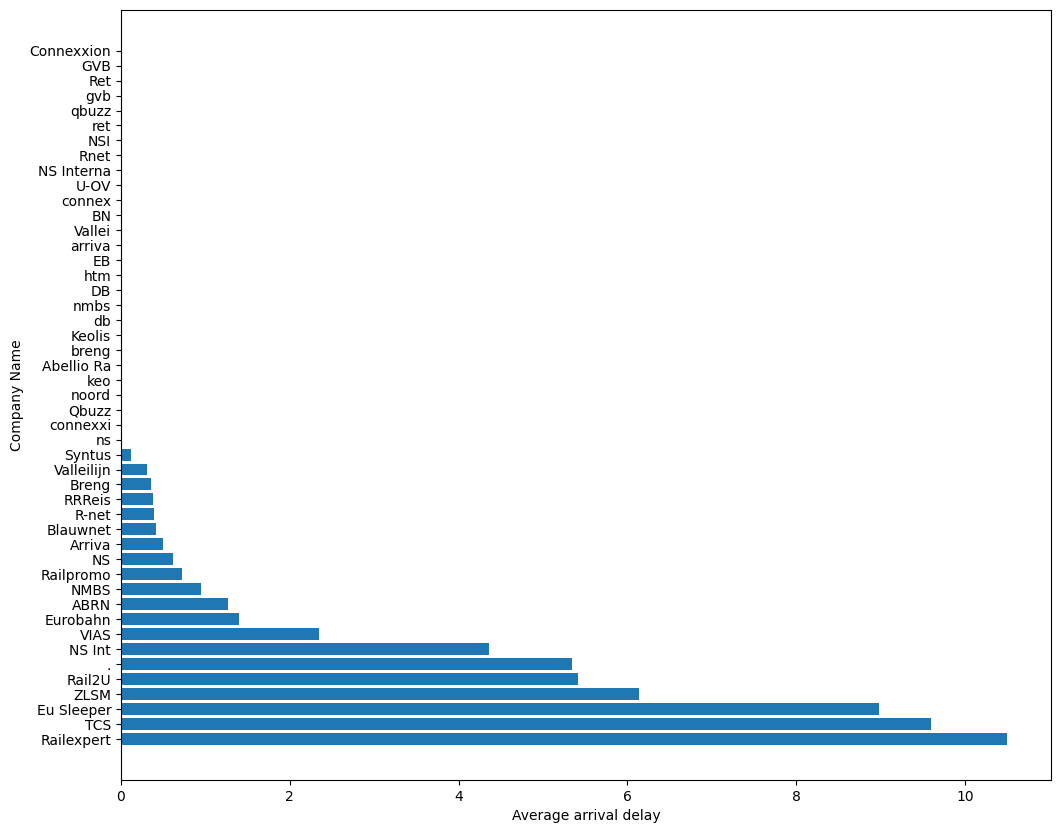

In [214]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 10))

ax.barh(arrival_delays["Service:Company"], arrival_delays["avg_delay"])
ax.set_ylabel("Company Name")
ax.set_xlabel("Average arrival delay")

plt.show()

#### 8.

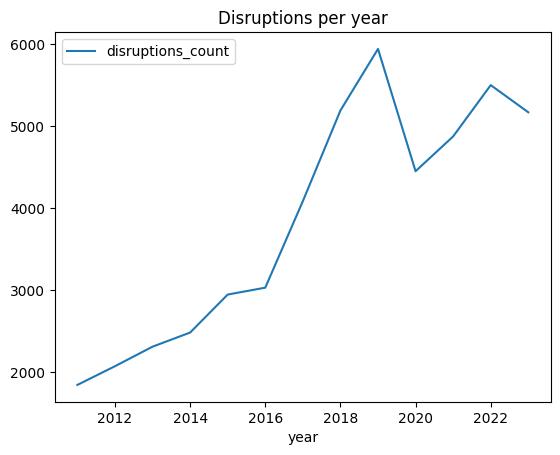

In [230]:
db.sql("""
SELECT YEAR(start_time) as year, COUNT(*) as disruptions_count FROM postgres_db.disruptions
GROUP BY year
ORDER BY year
""").df().plot.line(x="year", y="disruptions_count", title="Disruptions per year");

In [231]:
# What fraction of all services were cancelled (`Service:Completely cancelled`) in different years? Make a line plot.

In [233]:
db.sql("""
SELECT * FROM services
LIMIT 1
""")

┌────────────────┬──────────────┬──────────────┬─────────────────┬──────────────────────┬──────────────────────────────┬──────────────────────────┬───────────────────────┬─────────────┬───────────────────┬────────────────────┬───────────────────┬────────────────────┬────────────────────────┬─────────────────────┬──────────────────────┬──────────────────────────┬──────────────────────┬───────────────────────┬──────────────────────┐
│ Service:RDT-ID │ Service:Date │ Service:Type │ Service:Company │ Service:Train number │ Service:Completely cancelled │ Service:Partly cancelled │ Service:Maximum delay │ Stop:RDT-ID │ Stop:Station code │ Stop:Station name  │ Stop:Arrival time │ Stop:Arrival delay │ Stop:Arrival cancelled │ Stop:Departure time │ Stop:Departure delay │ Stop:Departure cancelled │ Stop:Platform change │ Stop:Planned platform │ Stop:Actual platform │
│     int64      │     date     │   varchar    │     varchar     │        int64         │           boolean            │         b

#### 9.

<Axes: xlabel='year'>

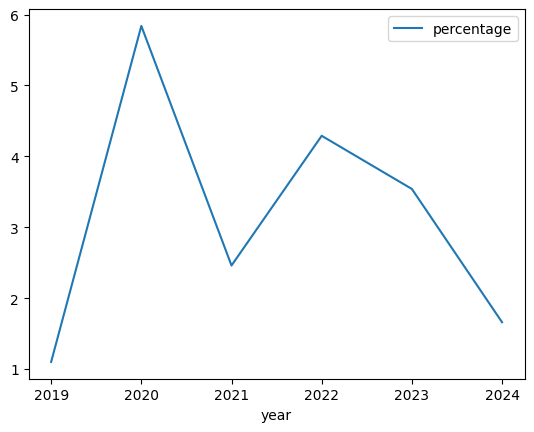

In [247]:
db.sql("""
SELECT 
       YEAR("Service:Date") as year, 
       ROUND(AVG(CASE WHEN "Service:Completely cancelled" = true THEN 1 ELSE 0 END) * 100, 2) as percentage
    FROM services
GROUP BY year
ORDER BY year
""").df().plot.line(x="year", y="percentage")

### 3.

In [260]:
db.sql("""
SELECT
*
FROM services
""")

┌────────────────┬──────────────┬──────────────┬─────────────────┬──────────────────────┬──────────────────────────────┬──────────────────────────┬───────────────────────┬─────────────┬───────────────────┬─────────────────────────┬─────────────────────┬────────────────────┬────────────────────────┬─────────────────────┬──────────────────────┬──────────────────────────┬──────────────────────┬───────────────────────┬──────────────────────┐
│ Service:RDT-ID │ Service:Date │ Service:Type │ Service:Company │ Service:Train number │ Service:Completely cancelled │ Service:Partly cancelled │ Service:Maximum delay │ Stop:RDT-ID │ Stop:Station code │    Stop:Station name    │  Stop:Arrival time  │ Stop:Arrival delay │ Stop:Arrival cancelled │ Stop:Departure time │ Stop:Departure delay │ Stop:Departure cancelled │ Stop:Platform change │ Stop:Planned platform │ Stop:Actual platform │
│     int64      │     date     │   varchar    │     varchar     │        int64         │           boolean         

In [282]:
db.sql("""
SELECT * FROM services
WHERE "Service:RDT-ID" = 4867421
""")

┌────────────────┬──────────────┬──────────────┬─────────────────┬──────────────────────┬──────────────────────────────┬──────────────────────────┬───────────────────────┬─────────────┬───────────────────┬────────────────────────┬─────────────────────┬────────────────────┬────────────────────────┬─────────────────────┬──────────────────────┬──────────────────────────┬──────────────────────┬───────────────────────┬──────────────────────┐
│ Service:RDT-ID │ Service:Date │ Service:Type │ Service:Company │ Service:Train number │ Service:Completely cancelled │ Service:Partly cancelled │ Service:Maximum delay │ Stop:RDT-ID │ Stop:Station code │   Stop:Station name    │  Stop:Arrival time  │ Stop:Arrival delay │ Stop:Arrival cancelled │ Stop:Departure time │ Stop:Departure delay │ Stop:Departure cancelled │ Stop:Platform change │ Stop:Planned platform │ Stop:Actual platform │
│     int64      │     date     │   varchar    │     varchar     │        int64         │           boolean           

In [318]:
db.sql("""
CREATE TABLE station_connections AS
SELECT "Service:RDT-ID", start_station_code, end_station_code, dl.distance FROM (
    SELECT
        "Service:RDT-ID",
        FIRST_VALUE("Stop:Station code") OVER w as start_station_code,
        LAST_VALUE("Stop:Station code") OVER w end_station_code,
        "Stop:Departure time" as dep_time
    FROM services
    WINDOW
    w AS (PARTITION BY "Service:RDT-ID" ORDER BY COALESCE("Stop:Departure time", 'infinity'))
) AS subquery
LEFT JOIN distances_long as dl on dl.station = start_station_code and dl.other_station = end_station_code
WHERE dep_time is NULL
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

<Axes: xlabel='end-to-end distance', ylabel='Frequency'>

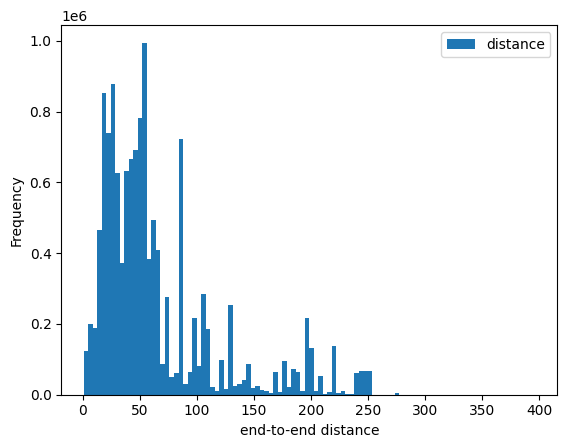

In [324]:
db.sql("SELECT distance FROM station_connections").df().plot.hist(bins=100, xlabel="end-to-end distance")